# TF2 and Keras - CNN 구현하기

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


지금부터 고속도로 속도 예측을 위한간단한 CNN을 구현해보겠습니다.

간단한 예제이므로, 3개의 Convolution layer 와 1개의 fully connected layer로
구성된 CNN을 설계하겠습니다.

처음 선언부는 아래와 같습니다.


In [0]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

path = '/content/drive/My Drive/dnn_tutorial/'
#   set LABEL first
output_cols = ['vel']
#   set traffic column
input_cols = ['vel_t05', 'vel_t10', 'vel_t15', 'vel_t20',
               'vel_t25', 'vel_t30', 'vel_t35',  'vel_t40']

이제 방금 말한 CNN을 Sequential layer로 구현하겠습니다.
ANN 과는 다르게 처음에 Reshape layer가 들어갑니다.
이는 입력 데이터가 1 channel 1D array 형태로 인식시키기 위함입니다.


In [0]:
model = keras.Sequential()
model.add(keras.layers.Reshape(( len(input_cols), 1), 
                               input_shape = ( len(input_cols), )))
model.add(keras.layers.Conv1D(10, kernel_size=[2], padding="same",
                              data_format='channels_last', activation='relu'))
model.add(keras.layers.MaxPool1D(pool_size=2, padding="valid",
                                 data_format='channels_last'))
model.add(keras.layers.Conv1D(10, kernel_size=[2], padding="valid",
                              data_format='channels_last', activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(1, activation=None))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
              loss='mse', metrics=['mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 8, 1)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 10)             30        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 10)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 10)             210       
_________________________________________________________________
flatten (Flatten)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

이제 training data를 읽어서 model 을 학습시키겠습니다.


In [0]:
train_data = pd.read_csv(path+'traffic_data_train.csv', index_col = 0)
X_train = train_data[input_cols].values
Y_train = train_data[output_cols].values

model.fit(X_train, Y_train, batch_size=1024, epochs= 10)

Epoch 1/10
101/101 [==============================] - 1s 6ms/step - loss: 1673.5934 - mape: 30.8497
Epoch 2/10
101/101 [==============================] - 1s 5ms/step - loss: 23.0433 - mape: 3.6002
Epoch 3/10
101/101 [==============================] - 1s 6ms/step - loss: 19.4585 - mape: 3.3538
Epoch 4/10
101/101 [==============================] - 1s 5ms/step - loss: 18.2449 - mape: 3.2798
Epoch 5/10
101/101 [==============================] - 1s 5ms/step - loss: 17.3940 - mape: 3.2391
Epoch 6/10
101/101 [==============================] - 1s 6ms/step - loss: 17.0085 - mape: 3.1948
Epoch 7/10
101/101 [==============================] - 1s 5ms/step - loss: 16.7212 - mape: 3.1721
Epoch 8/10
101/101 [==============================] - 1s 5ms/step - loss: 16.4754 - mape: 3.1342
Epoch 9/10
101/101 [==============================] - 1s 5ms/step - loss: 16.3474 - mape: 3.1260
Epoch 10/10
101/101 [==============================] - 1s 6ms/step - loss: 16.3640 - mape: 3.1328


이제 이전 예제와 마찬가지로 test data를 통해 evaluate 해보겠습니다.


In [0]:
test1_data = pd.read_csv(path+'traffic_data_test1.csv', index_col = 0)
X_test1 = test1_data[input_cols].values
Y_test1 = test1_data[output_cols].values

model.evaluate(X_test1, Y_test1)


32/32 [==============================] - 0s 1ms/step - loss: 13.3714 - mape: 3.1207


[13.37142276763916, 3.1206624507904053]

마지막으로 하루치 데이터에 대한 예측과 그래프를 그려보도록 하겠습니다.

9/9 [==============================] - 0s 1ms/step - loss: 54.5710 - mape: 9.0505


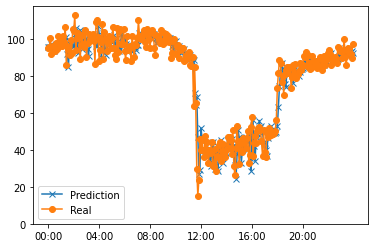

In [0]:
test2_data = pd.read_csv(path+'traffic_data_test2.csv', index_col = 0)
test2_data['date'] = pd.to_datetime(test2_data['date'], format='%Y%m%d')
test2_data['time'] = test2_data['time'].map(
                        lambda x: pd.Timedelta(hours=x // 100, minutes=x % 100))
test2_data['datetime'] = test2_data['date'] + test2_data['time']

X_test2= test2_data[input_cols].values
Y_test2 =  test2_data[output_cols].values
model.evaluate(X_test2, Y_test2)
prediction = model.predict(X_test2)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.plot(prediction,'-x',Y_test2, '-o')
ax.set_ylim(bottom=0)
xtick_list = [x for x in range(
        0, len(Y_test2), len(Y_test2) // 6)]
ax.set_xticks(xtick_list)
ax.set_xticklabels([test2_data['datetime'][x].strftime('%H:%M') for x in xtick_list])
ax.legend(['Prediction', 'Real'])
